# Monte Carlo and Fast Exponential Transform

## Problem 0 (45 points) - Metroplis-Hastings algorithm

Suppose we have 10 particles with positions $x_i$  resting in potential well $V(x)= x^4-x^2-0.1x$:

Text(0, 0.5, 'V(x)')

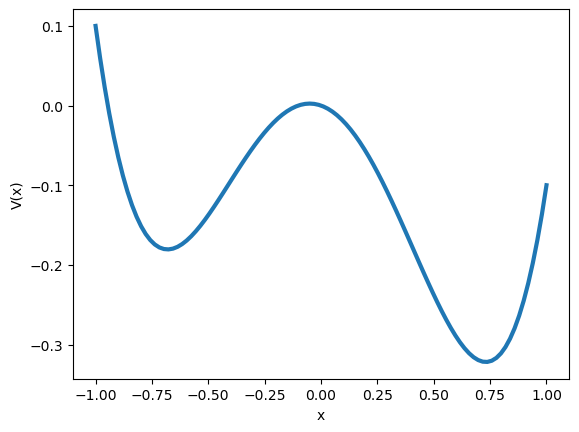

In [1]:
import numpy as np
import matplotlib.pyplot as plt

V = lambda x: x**4 - x**2 - 0.1*x # confining potential

xx = np.linspace(-1, 1, 100)
plt.plot(xx, V(xx), linewidth=3)
plt.xlabel('x')
plt.ylabel('V(x)')

If the particles have charges $q_i$, then the total energy of the system is
$$
H(\boldsymbol{x}) = \sum_{\text{pairs} (i,j)} \frac{q_iq_j}{|x_i-x_j|} + \sum_i V(x_i).
$$
According to satistical physics, if the particles are in thermal equillibrium at temperature $T$, then probability distribution of particles will be
$$
p(\boldsymbol{x}) = Z^{-1} e^{-H(\boldsymbol{x})/T},
$$
where $Z$ is a normalizing constant.


We will use the Metroplis-Hastings algorithm to find the expected number of particles in the right well ($x>0$).

The following function will generate our initial condition.

In [2]:
def gen_pts(npart=10):
    ' Generate n charged particles with random positions and charges '
    xs = 2*np.random.rand(npart) - 1# uniformly distributed intial condition
    qs = np.random.rand(npart)
    return xs, qs

### Part A (5 points)
In the Metroplis-Hastings algorithm, we propose a new sample based on the previous sample:
$$
\boldsymbol{y}_{k+1} = F_i(\boldsymbol{x}_{k})
$$
For this problem, we shall need three kinds of steps one for moving our particles. In the first kind of step, which we call `walk_step`, will move the particles slightly:
$$
y_{i,k+1} = x_{i,k} + \delta W_{i,k},
$$
where $W_{i,k}$ is a standard normal random variable.
In the second kind of step (`swap_step`), we will randomly permute the particles:
$$
y_{i,k+1} = x_{P(i),k},
$$
where $P$ is a random parmutation.
The final kind of step (`flip_step`) will move one random particle ($j_k$) to the other well.
$$ 
y_{i,k+1} = \begin{cases} -x_{i,k} & i == j_{k}\\ x_{i,k} &\text{o.w.}\end{cases}
$$

The overall rule for generating the $y_{i,k+1}$ will be to do a `swap_step` with probability $a$, a `flip_step` with probability $b$, or `walk_step` if we do neither of the other steps.

Once we have generated the proposed step $\boldsymbol{y}_{k+1}$, the Metroplis-Hastings algorithm says that we accept it (i.e. set $\boldsymbol{x}_{k+1}=\boldsymbol{y}_{k+1}$) with probability $\min(p(\boldsymbol{y}_{k+1})/p(\boldsymbol{x}_{k}),1)$. If the step is rejectect, we set $\boldsymbol{x}_{k+1}=\boldsymbol{x}_{k}$.

Fill in the functions below to allow us to generate the next sample in the Metrpolis-Hastings alogirthm.

In [3]:
def walk_step(xs, delta = 0.1):
    '''
    move the particles by a small random step
    
    xs: positions of particles
    delta: step size
    '''
    return xs + delta * np.random.randn(len(xs))

def swap_step(xs):
    '''
    permutate the positions of particles
    
    xs: positions of particles
    '''
    return np.random.permutation(xs)

def flip_step(xs):
    '''
    flip the position of one random particle
    
    xs: positions of particles
    '''
    j = np.random.randint(0, len(xs))
    ys = np.copy(xs)
    ys[j] = -ys[j]
    return ys

def mc_step(xs, p, a=0.1, b=0.1):
    '''
    generate a new random sample 
    
    xs: positions of particles
    p: probability function
    a: probability of performing swap_step
    b: probability of performing flip_step
    '''
    
    r = np.random.rand()
    
    if r <= a:
        ys = swap_step(xs)
    elif r <= a + b:
        ys = flip_step(xs)
    else:
        ys = walk_step(xs)
    
    if np.random.rand() <= min(p(ys)/p(xs), 1):
        return ys
    else:
        return xs

### Part B (15 points) - Note the weight of this question
A Monte Carlo scheme will only converge quickly if the generated samples rapidly explore the state space (i.e. the potential particle positions).

Technically `walk_step` is capable of reordering the particles and moving particles to the other well and therefore exploring the state space.
Why will introducing `swap_step` and `flip_step` allow our scheme to converge faster? 

1. If we only use `walk_step`, which moves the particles by small increments, it's highly likely that the particles will be trapped in the potential well and biased towards the initial condition. As a result, the algorithm may take a long time to thoroughly explore the state space. 
2.  The `swap_step` and `flip_step` effectively change the states of the system, producing a more diverse and less correlated set of states. This allows for faster convergence.

### Part C (10 points)
Complete the function `mcmc_sim`, which generates the samples $\boldsymbol{x}_{1},\;\boldsymbol{x}_{2},\;\ldots$. You will need to initialize the system with `gen_part` and then run `nburn` steps to allow the system to converge to it's equillibrium distribution. After that initialization period, generate `nsamp` new samples and save them. The function should then return those saved samples.

Once the function is completed, use it with `nsamp = 10**4` and `nburn = 10**2` to estimate the number of particles in the right well.

In [4]:
def mcmc_sim(nsamp, nburn, npart=10, T = 2):
    '''
    generate samples using mcmc
    
    nsamp: total number of samples
    nburn: burning step
    npart: number of particles
    T: temperature
    '''
    
    xs, qs = gen_pts(npart)
    
    
    def H(xs, qs):
        '''
        implement the total energy of the system
        '''
        pairwise_interaction = 0

        n = len(xs)

        for i in range(n):
            for j in range(i+1, n):
                pairwise_interaction += (qs[i] * qs[j]) / np.abs(xs[i] - xs[j])

        potential = np.sum(V(xs))

        return pairwise_interaction + potential
    
    # probability distribution
    p = lambda xs:np.exp(-H(xs, qs)/T)
    
    
    x = xs.copy()
    for _ in range(nburn):
        x = mc_step(x, p)
    
    samples = [x]
    
    for _ in range(nsamp):
        x = mc_step(x, p)
        samples.append(x)
        
    return np.array(samples)



In [5]:
nsamp = 10**4
nburn = 10**2
samples = mcmc_sim(nsamp, nburn)

avg_particles_in_right_well = np.mean(np.sum(samples > 0, axis=1))
print("estimated number of particles in the right well: ", avg_particles_in_right_well)

estimated number of particles in the right well:  5.129087091290871


### Part D (5 points)
Make a histogram of the particle positions using the same samples as in the previous question. Note that for this problem, we don't distinguish between particles $i$ and $j$, so you should "flatten" the samples into a one-dimensional array  before plotting.

Text(0.5, 0, 'x-position')

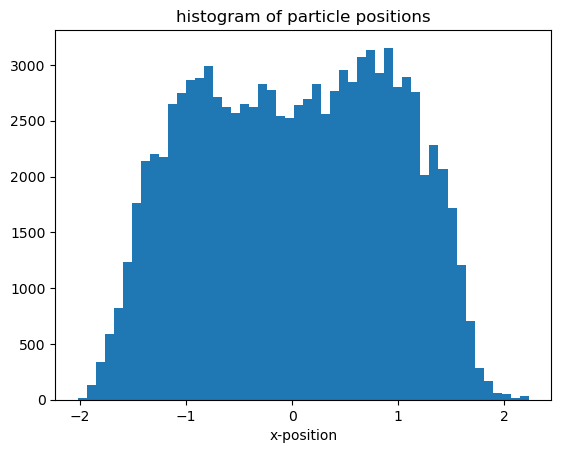

In [6]:
flattened_samples = samples.flatten()

plt.hist(flattened_samples, bins=50)
plt.title("histogram of particle positions")
plt.xlabel("x-position")

### Part E (10 points)
For this problem set `nsamp = 10**3`. Compare the estimate with `nburn = 0` and `nburn = 10**3`. Which one is closer to your estimate from the previous question and why?

In [7]:
nsamp = 10**3


nburn_1 = 0
nburn_2 = 10**3

samples_1 = mcmc_sim(nsamp, nburn_1)
samples_2 = mcmc_sim(nsamp, nburn_2)

avg_particles_in_right_well_1 = np.mean(np.sum(samples_1 > 0, axis=1))
avg_particles_in_right_well_2 = np.mean(np.sum(samples_2 > 0, axis=1))

print("estimate the number of particles in the right well (nburn=0):", avg_particles_in_right_well_1)
print("estimate the number of particles in the right well (nburn=10**2):", avg_particles_in_right_well)
print("estimate the number of particles in the right well (nburn=10**3):", avg_particles_in_right_well_2)

estimate the number of particles in the right well (nburn=0): 4.648351648351649
estimate the number of particles in the right well (nburn=10**2): 5.129087091290871
estimate the number of particles in the right well (nburn=10**3): 5.207792207792208


The result of `nburn=10**3` is closer to my previous answer, because the burn-in procedure enables the algorithm to achieve equilibrium and generate representative samples. However, when there's no burn-in (`nburn=0`), the result is unstable and influenced by the initial conditions.

## Problem 1 (30 points) - Fast Exponential Transform

In this problem, we will experiment with a common fast algorithm for applying exponential functions in 1D. Suppose we have sorted points $x_0,\dots,x_{n-1} \in \mathbb{R}$ and "weights" $c_0,\dots,c_{n-1}$ and we want to compute the sum
$$f_i = \sum_{j=0}^{n-1} \exp(-|x_i-x_j|) c_j,$$
for $i=0,1,2,\dots,n-1.$ 

### Part A (5 points)

The most straightforward way to find $f_0,\dots,f_{n-1}$ is via linear algebra. Make a big matrix $E$ with $E_{i,j}= \exp(-|x_i-x_j|).$ If we set $c$ to be the vector of weights, and $f$ to be the vector of values we want, then we get
$$f = Ec.$$

Implement a routine `exp_transform(x,c)` which takes in a vector of $x$ "positions" ($x_0<x_1<\dots<x_{n-1}$) and a vector of weights $c$ and outputs the corresponding $f$ values as a vector using this approach.

Test its performance in terms of time by taking 200,400,800,1600,3200,6400,10000 random normal numbers for the $x$ positions and setting all of the $c$'s to be one (only time the `exp_transform(x,c)` routine, not the time to generate $x$ or sort it). Plot your results. If the latter trials are taking too long then feel free to exclude them from your results (just make a note).

In [8]:
## Your code here
def exp_transform(x, c):
    '''
    apply exponential function using matrix multiplication
    
    x: sorted points
    c: weights
    '''
    
    n = len(x)
    E = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            E[i][j] = np.exp(-np.abs(x[i] - x[j]))
    
    f = E @ c
    
    return f

In [9]:
import time


ns = [200,400,800,1600,3200,6400,10000]


results = []
for n in ns:
    x = np.sort(np.random.randn(n))
    c = np.ones(n)
    
    t1 = time.time()
    exp_transform(x, c)
    t2 = time.time()
    
    results.append(t2 - t1)
    


Finish:  200
Finish:  400
Finish:  800
Finish:  1600
Finish:  3200
Finish:  6400
Finish:  10000


Text(0, 0.5, 'time (s)')

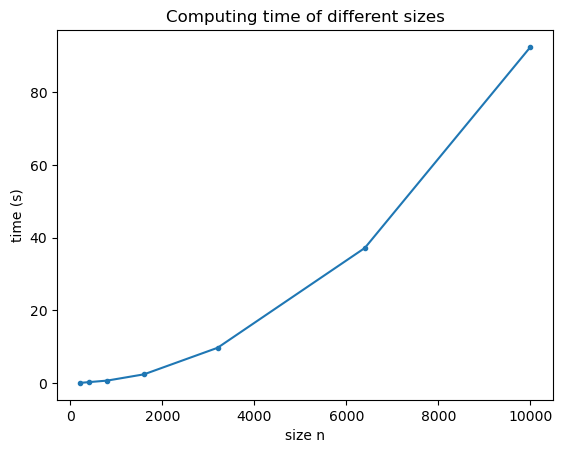

In [10]:
plt.plot(ns, results, marker='.')
plt.title("Computing time of different sizes")
plt.xlabel("size n")
plt.ylabel("time (s)")

The complexity of this algorithm is about $O(n^2)$, which will get very slow for large n.

Unfortunately, for large $n,$ (think 10's of thousands to millions) creating and storing $E$ can get expensive, and applying the matrix will take $O(n^2)$ operations. Let's try to find a better way. For a given point $x_i$ let $L_i$ be the collection of all the points to the left of $x_i$ and $R_i$ be the collection of all points to the right of $x_i.$ Then

$$ f_i = c_i + \sum_{j \in L_i} \exp(x_j-x_i) c_j +\sum_{j \in R_i} \exp(x_i-x_j) c_j.$$

Set $w_i = \sum_{j \in L_i} \exp(x_j-x_i) c_j,$ and $u_i = \sum_{j \in R_i} \exp(x_i-x_j) c_j.$ Then, after some arithmetic, we see that
$$w_{i+1} = \exp(x_i-x_{i+1}) (w_i + c_i)$$
and
$$u_{i-1} = \exp(x_{i-1}-x_{i}) (u_i + c_i)$$

### Part B (10 points)

Write a function, `sweep_right(x,c)` which computes all the $w$'s using the above recurrence formula. Your routine should start with $w_0 = 0,$ and compute $w_1 = \exp(x_0-x_1)*c_0,$ then $w_2 = \exp(x_1-x_2)*(w_1+c_1),$ and so on.

Write a function, `sweep_left(x,c)` which computes all the $u$'s using the above recurrence formula. Your routine should start with $u_{n-1} = 0,$ and compute $u_{n-2} = \exp(x_{n-2}-x_{n-1})*c_{n-1},$ then $u_{n-3} = \exp(x_{n-3}-x_{n-2})*(u_{n-2}+c_{n-2}),$ and so on. When implementing this method, it might be helpful to use `numpy.flip` to reverse the $x$ and $c$ vectors to make your code look similar to `sweep_right` - just make sure to check the signs in the exponents and to make sure that the output is flipped properly.

In [11]:
## Your code here
def sweep_right(x, c):
    '''
    compute w to the right of x
    '''
    
    n = len(x)
    w = np.zeros(n)
    
    for i in range(1, n):
        w[i] = np.exp(x[i-1] - x[i]) * (w[i-1] + c[i-1])
    
    return w

def sweep_left(x, c):
    '''
    compute u to the left of x
    '''
    n = len(x)
    u = np.zeros(n)
    
    for i in range(n-2, -1, -1):
        u[i] = np.exp(x[i] - x[i+1]) * (u[i+1] + c[i+1])
    
    return u



### Part C (10 points)

Write a function `fast_exp_transform(x,c)` which takes in a vector of $x$ "positions" ($x_0<x_1<\dots<x_{n-1}$) and a vector of weights $c$ and outputs the corresponding $f$ values as a vector using your `sweep_left` and `sweep_right` functions and the formula above.

Test its accuracy against `exp_transform` for a small number of points (100 let's say).

Test its performance in terms of time by taking 200,400,800,1600,3200,6400,10000 random normal numbers for the $x$ positions and setting all of the $c$'s to be one (only time the `fast_exp_transform(x,c)` routine, not the time to generate $x$ or sort it). Plot your results. *Make sure the points are sorted!* 

How many points can you do? 

What is the crossover point between this approach and `exp_transform` if any? i.e. for what value of $n$ will the two take about the same time?

What is the computational complexity (in $n$) of your `fast_exp_transform` code?

In [12]:
## Your code here
def fast_exp_transform(x, c):
    w = sweep_right(x, c)
    u = sweep_left(x, c)
    
    f = c + w + u
    
    return f

x = np.sort(np.random.randn(100))
c = np.ones(100)

fast_result = fast_exp_transform(x, c)
orig_result = exp_transform(x, c)

print("The sum of squares error is:", np.sum((fast_result - orig_result) ** 2))

The sum of squares error is: 3.219341354206949e-27


In [13]:
import time


ns = [200,400,800,1600,3200,6400,10000]


results_fast = []
for n in ns:
    x = np.sort(np.random.randn(n))
    c = np.ones(n)
    
    t1 = time.time()
    fast_exp_transform(x, c)
    t2 = time.time()
    
    results_fast.append(t2 - t1)
    print("Finish: ", n)

Finish:  200
Finish:  400
Finish:  800
Finish:  1600
Finish:  3200
Finish:  6400
Finish:  10000


Text(0, 0.5, 'time (s)')

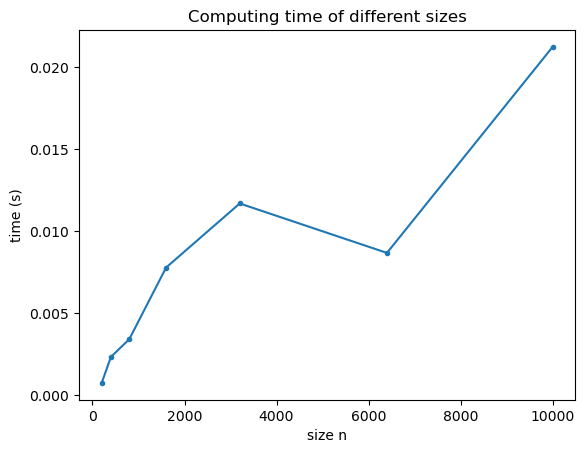

In [14]:
plt.plot(ns, results_fast, marker='.')
plt.title("Computing time of different sizes")
plt.xlabel("size n")
plt.ylabel("time (s)")

In [15]:
import time


ns = [1, 10, 50]


results_fast = []
results = []
for n in ns:
    x = np.sort(np.random.randn(n))
    c = np.ones(n)
    
    t1 = time.time()
    fast_exp_transform(x, c)
    t2 = time.time()
    
    
    results_fast.append(t2 - t1)
    
    t1 = time.time()
    exp_transform(x, c)
    t2 = time.time()
    
    
    results.append(t2 - t1)
    print("Finish: ", n)

Finish:  1
Finish:  10
Finish:  50


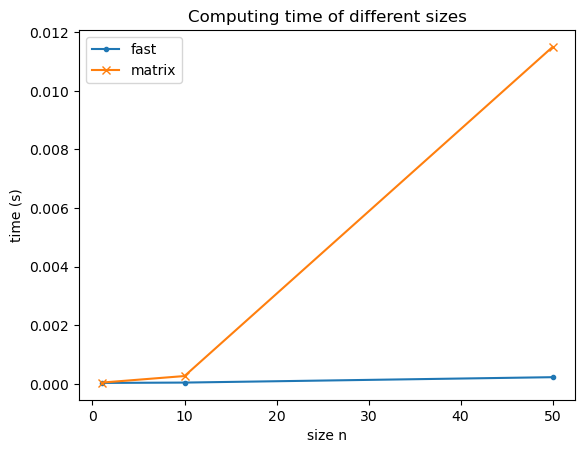

In [16]:
plt.plot(ns, results_fast, marker='.', label='fast')
plt.plot(ns, results, marker='x', label="matrix")
plt.title("Computing time of different sizes")
plt.xlabel("size n")
plt.ylabel("time (s)")
plt.legend()

The `fast_exp_transform` can perform the exponential transformation of a vector of size 10,000 in around 0.02 seconds, which is about 5,000 to 6,000 times faster compared to the linear algebra method. The `fast_exp_transform` is consistently faster than the `exp_transform`, so there is no crossover point.

The complexity is $O(n)$. `sweep_right` and `sweep_left` each contain a loop of n iterations and the remaining addition takes approximately constant time, so the total algorithm takes $O(2n) = O(n)$ time, which is also evident from the graph above.

### Part D (5 points)

Try to optimize both codes as much as possible. For example, you could try to vectorize the construction of the exponentials in the first approach. You could try to use `numba` to try to accelerate the second. You can precompute the exponentials of the distances between consecutive $x$ values and pass that as an optional argument to your sweeping routines. How much can you improve your code? This is an open-ended question and there is no "right" answer. 

#### improve exp_transform

In [17]:
## Your code here
def vec_exp_transform(x, c):
    '''
    apply exponential function using matrix multiplication with vectorization
    
    x: sorted points
    c: weights
    '''
    E = np.exp(-np.abs(x[:, np.newaxis] - x))
    
    f = E @ c
    
    return f

In [18]:
ns = [200,400,800,1600,3200,6400,10000]


results_vec = []
results = []
for n in ns:
    x = np.sort(np.random.randn(n))
    c = np.ones(n)
    
    t1 = time.time()
    vec_exp_transform(x, c)
    t2 = time.time()
    

    results_vec.append(t2 - t1)
    
    t1 = time.time()
    exp_transform(x, c)
    t2 = time.time()
    
    
    results.append(t2 - t1)
    print("Finish: ", n)

Finish:  200
Finish:  400
Finish:  800
Finish:  1600
Finish:  3200
Finish:  6400
Finish:  10000


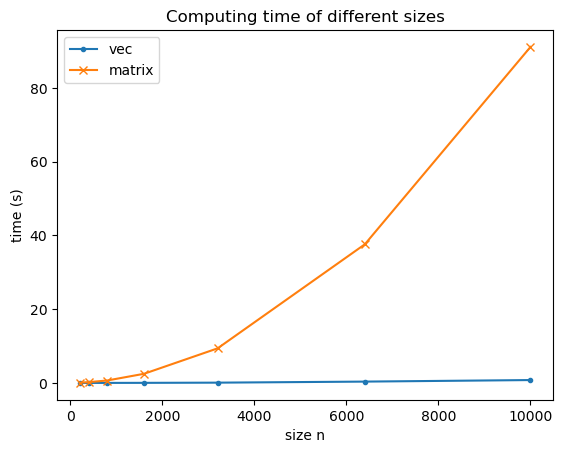

In [19]:
plt.plot(ns, results_vec, marker='.', label='vec')
plt.plot(ns, results, marker='x', label="matrix")
plt.title("Computing time of different sizes")
plt.xlabel("size n")
plt.ylabel("time (s)")
plt.legend()

After vectorizing construction, we can complete the computation in seconds rather than several minutes. It's clear that the construction of the matrix is a bottleneck.

#### improve fast_exp_transform

In [20]:
from numba import jit, njit

@jit
def jit_sweep_right(x_diff_exp, c):
    '''
    Compute w to the right of x
    '''
    n = len(c)
    w = np.zeros(n)
    
    for i in range(1, n):
        w[i] = x_diff_exp[i-1] * (w[i-1] + c[i-1])
    
    return w

@jit
def jit_sweep_left(x_diff_exp, c):
    '''
    Compute u to the left of x
    '''
    n = len(c)
    u = np.zeros(n)
    
    for i in range(n-2, -1, -1):
        u[i] = x_diff_exp[i] * (u[i+1] + c[i+1])
    
    return u

def jit_fast_exp_transform(x, c):
    x_diff_exp = np.exp(-np.diff(x))  # precompute the exponentials of the distances
    
    w = jit_sweep_right(x_diff_exp, c)
    u = jit_sweep_left(x_diff_exp, c)
    
    f = c + w + u
    
    return f



In [21]:
ns = [200,400,800,1600,3200,6400,10000, 1000000]


results_fast = []
results_jit = []
for n in ns:
    x = np.sort(np.random.randn(n))
    c = np.ones(n)
    
    t1 = time.time()
    fast_exp_transform(x, c)
    t2 = time.time()
    
    
    results_fast.append(t2 - t1)
    
    t1 = time.time()
    jit_fast_exp_transform(x, c)
    t2 = time.time()
    
    
    results_jit.append(t2 - t1)
    print("Finish: ", n)

Finish:  200
Finish:  400
Finish:  800
Finish:  1600
Finish:  3200
Finish:  6400
Finish:  10000
Finish:  1000000


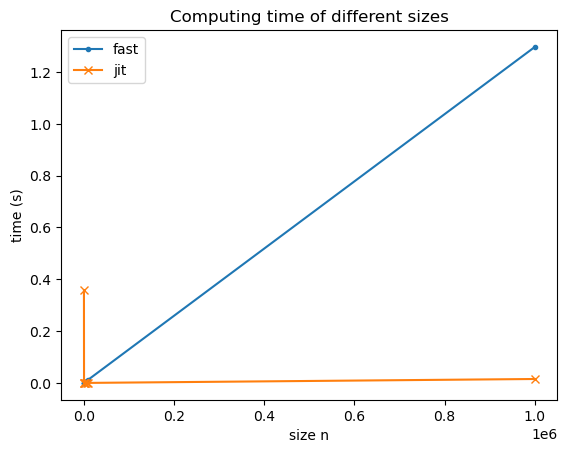

In [22]:
plt.plot(ns, results_fast, marker='.', label='fast')
plt.plot(ns, results_jit, marker='x', label="jit")
plt.title("Computing time of different sizes")
plt.xlabel("size n")
plt.ylabel("time (s)")
plt.legend()

After using `numba`, we can further accelerate the computation of `fast_exp_transform` by around 100 times.